In [1]:
import torch
torch.cuda.empty_cache()
import torchvision
from torchvision import datasets as ds, transforms, models 
from torchvision.transforms import InterpolationMode
from torchvision.models import resnet18, mobilenet_v2, MobileNet_V2_Weights
from transformers import DistilBertModel, DistilBertTokenizer, AdamW, AutoProcessor, get_scheduler, AutoModelForCausalLM, AutoTokenizer
from torch.utils.data import DataLoader, Dataset 

import sys
sys.path.append('/home/poz/Notebooks/645_Assignment2')
# from myDefsnClasses import imshow, DistilBERTClassifier, read_text_files_with_labels, train, evaluate, predict, MultiInputModel, MultiModalDataset, fullTrain

# import multiprocessing
# if __name__ == "__main__":
#     multiprocessing.set_start_method("fork")
#     torch.multiprocessing.set_sharing_strategy('file_system')

import torch.nn as nn
import torch.nn.functional as F

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from PIL import ImageOps, Image
from tqdm import tqdm
from sklearn.metrics import confusion_matrix
import seaborn as sns
from datetime import datetime

import torch.optim as optim
from torch.optim.lr_scheduler import ExponentialLR

import re
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"
os.environ['TORCH_USE_CUDA_DSA'] = "1"
os.environ['TF_ENABLE_ONEDNN_OPTS'] = "0"

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
torch_dtype = torch.float16 if torch.cuda.is_available() else torch.float32
print('CUDA available', torch.cuda.is_available())
print('CUDA version', torch.version.cuda)
print('cuDNN enabled', torch.backends.cudnn.enabled)
print('cuDNN version', torch.backends.cudnn.version())
print("PyTorch version:", torch.__version__)
print("Torchvision version:", torchvision.__version__)

n_cuda_devices = torch.cuda.device_count()
for i in range(n_cuda_devices):
  print(f'Device {i} name:', torch.cuda.get_device_name(i))

batch_size = 32
image_resize = 224
num_workers = 8
num_epochs = 6
max_len = 48
best_loss = 1e+10
learning_rate = 2e-5
stats = (torch.tensor([0.4482, 0.4192, 0.3900]), torch.tensor([0.2918, 0.2796, 0.2709]))

2025-02-18 22:37:59.080157: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1739943479.092639   50259 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1739943479.096440   50259 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-02-18 22:37:59.109280: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


CUDA available True
CUDA version 12.4
cuDNN enabled True
cuDNN version 90100
PyTorch version: 2.6.0+cu124
Torchvision version: 0.21.0+cu124
Device 0 name: NVIDIA GeForce RTX 2080 Ti


In [40]:
# Modify the imshow function to ensure stats are on the same device as the image
def imshow(img, stats):
    mean = stats[0].view(3, 1, 1).to(img.device)
    std = stats[1].view(3, 1, 1).to(img.device)
    img = img * std + mean
    npimg = img.cpu().numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

# Define the text model
class DistilBERTClassifier(nn.Module):
    def __init__(self, num_classes):
        super(DistilBERTClassifier, self).__init__()
        self.distilbert = DistilBertModel.from_pretrained('distilbert-base-uncased')
        self.drop = nn.Dropout(0.3)
        self.out = nn.Linear(self.distilbert.config.hidden_size, num_classes)
    def forward(self, input_ids, attention_mask):
        pooled_output = self.distilbert(input_ids=input_ids, attention_mask=attention_mask)[0]
        output = self.drop(pooled_output[:,0])
        return self.out(output)

# Extract text from file names as well as labels
def read_text_files_with_labels(path):
    texts = []
    labels = []
    class_folders = sorted(os.listdir(path))
    label_map = {class_name: idx for idx, class_name in enumerate(class_folders)}
    for class_name in class_folders:
        class_path = os.path.join(path, class_name)
        if os.path.isdir(class_path):
            file_names = os.listdir(class_path)
            for file_name in file_names:
                file_path = os.path.join(class_path, file_name)
                if os.path.isfile(file_path):
                    file_name_no_ext, _ = os.path.splitext(file_name)
                    text = file_name_no_ext.replace('_', ' ')
                    text_without_digits = re.sub(r'\d+', '', text)
                    texts.append(text_without_digits)
                    labels.append(label_map[class_name])
    return np.array(texts), np.array(labels)

# Define training function
def train(model, dataloader, optimizer, criterion, device):
    model.train()
    total_loss = 0
    for batch in dataloader:
        images = batch['image'].to(device)
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['label'].to(device)
        optimizer.zero_grad()
        output = model(images, input_ids, attention_mask)
        loss = criterion(output, labels)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    return total_loss / len(dataloader)

# Define evaluation function
def evaluate(model, dataloader, criterion, device):
    model.eval()
    total_loss = 0
    correct = 0
    total = 0
    with torch.no_grad():
        for batch in dataloader:
            images = batch['image'].to(device)
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['label'].to(device)
            output = model(images, input_ids, attention_mask)
            loss = criterion(output, labels)
            total_loss += loss.item()
            _, preds = torch.max(output, 1)
            correct += torch.sum(preds == labels).item()
            total += labels.size(0)
    accuracy = correct / total
    return total_loss / len(dataloader), accuracy

def predict(model, dataloader, device):
    model.eval()  # Set the model to evaluation mode
    predictions = []
    with torch.no_grad():  # Disable gradient tracking
        for batch in dataloader:
            images = batch['image'].to(device)
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            # Forward pass
            outputs = model(images, input_ids, attention_mask)
            _, preds = torch.max(outputs, dim=1)
            predictions.extend(preds.cpu().numpy())
    return predictions

class MultiInputModel(nn.Module):
    def __init__(self, num_classes):
        super(MultiInputModel, self).__init__()
        # Image model
        self.image_model = models.mobilenet_v2(weights=models.MobileNet_V2_Weights.DEFAULT)
        num_features = self.image_model.classifier[1].in_features
        self.image_model.classifier[1] = nn.Identity()
        # Adding additional convolutional and pooling layers to image model
        self.conv1 = nn.Conv2d(in_channels=num_features, out_channels=512, kernel_size=3, stride=1, padding=1)
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        self.conv2 = nn.Conv2d(in_channels=512, out_channels=256, kernel_size=3, stride=1, padding=1)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        # Text model
        self.text_model = DistilBertModel.from_pretrained('distilbert-base-uncased')
        self.text_fc = nn.Linear(self.text_model.config.hidden_size, 768)
        # Combining both image and text features
        self.fc1 = nn.Linear(1024, 256)
        self.fc2 = nn.Linear(256, 64)
        self.fc3 = nn.Linear(64, 16) 
        self.fc4 = nn.Linear(16, num_classes)
        self.dropout = nn.Dropout(0.3)
        # Set requires_grad = True for all parameters in MobileNetV2 and DistilBERT to fine-tune them
        for param in self.image_model.parameters():
            param.requires_grad = True  # Allow training of image model
        for param in self.text_model.parameters():
            param.requires_grad = True  # Allow training of text model
    def forward(self, image, input_ids, attention_mask):
        # Image features
        image_features = self.image_model.features(image)
        image_features = self.pool1(F.relu(self.conv1(image_features)))
        image_features = self.pool2(F.relu(self.conv2(image_features)))
        image_features = image_features.mean([2, 3])  # Global Average Pooling
        # Text features
        text_features = self.text_model(input_ids=input_ids, attention_mask=attention_mask)[0]
        text_features = text_features[:, 0, :]  # Use [CLS] token for classification
        text_features = self.text_fc(text_features)
        # Combine image and text features
        combined_features = torch.cat((image_features, text_features), dim=1)
        # Classifier with Activation functions, and Dropout
        x = self.fc1(combined_features)
        x = F.relu(x)
        x = self.dropout(x)
        x = self.fc2(x)
        x = F.relu(x)
        x = self.dropout(x)
        x = self.fc3(x)
        x = F.relu(x)
        x = self.dropout(x)
        x = self.fc4(x)
        return x

class MultiModalDataset(Dataset):
    def __init__(self, image_dataset, texts, labels, tokenizer, max_len):
        self.image_dataset = image_dataset
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len
    def __len__(self):
        return len(self.image_dataset)
    def __getitem__(self, idx):
        image, label = self.image_dataset[idx]
        label = self.labels[idx]
        text = str(self.texts[idx])
        encoding = self.tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length=self.max_len,
            return_token_type_ids=False,
            padding='max_length',
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt'
        )
        return {
            'image': image,
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'label': torch.tensor(label, dtype=torch.long)
        }

def predictALL(model, dataloader, device, class_names):
    correct_pred = {classname: 0 for classname in class_names}
    total_pred = {classname: 0 for classname in class_names}
    model.eval()
    showFirstTenMissClassed = 10
    with torch.no_grad():
        for batch in dataloader:
            images = batch['image'].to(device)
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['label'].to(device)
            outputs = model(images, input_ids, attention_mask)
            _, preds = torch.max(outputs, dim=1)
            for label, prediction, image in zip(labels, preds, images):
                if label == prediction:
                    correct_pred[class_names[label]] += 1
                if label != prediction:
                    if showFirstTenMissClassed >= 0:
                        print(f"This is classed as: {class_names[label]}\nThe model predicted class: {class_names[prediction]}")
                        imshow(image, stats)
                        showFirstTenMissClassed -= 1
                total_pred[class_names[label]] += 1
    for classname, correct_count in correct_pred.items():
        accuracy = 100 * float(correct_count) / total_pred[classname]
        print(f'Accuracy for class: {classname:5s} is {accuracy:.1f} %')

In [3]:
transform = {
    "train": transforms.Compose([
        transforms.Resize((232, 232), interpolation=InterpolationMode.BILINEAR),
        transforms.RandomCrop(image_resize),
        transforms.Resize((image_resize, image_resize)),
        transforms.RandomHorizontalFlip(),
        transforms.RandomVerticalFlip(),
        transforms.ColorJitter(brightness=0.2, contrast=0.2),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
    ]),
    "val": transforms.Compose([
        transforms.Resize((image_resize, image_resize)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
    ]),
    "test": transforms.Compose([
        transforms.Resize((image_resize, image_resize)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
    ]),
}

data_dir = r"/home/poz/garbage_data"
train_dir = os.path.join(data_dir, "CVPR_2024_dataset_Train")
val_dir = os.path.join(data_dir, "CVPR_2024_dataset_Val")
test_dir = os.path.join(data_dir, "CVPR_2024_dataset_Test")

text_train, labels_train = read_text_files_with_labels(train_dir)
text_val, labels_val = read_text_files_with_labels(val_dir)
text_test, labels_test = read_text_files_with_labels(test_dir)

datasets = {"train": ds.ImageFolder(train_dir, transform=transform["train"]),
            "val": ds.ImageFolder(val_dir, transform=transform["val"]),
            "test": ds.ImageFolder(test_dir, transform=transform["test"])}

class_names = datasets['train'].classes
print(class_names)

tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')

datasets = {"train": MultiModalDataset(datasets['train'], text_train, labels_train, tokenizer, max_len),
            "val": MultiModalDataset(datasets['val'], text_val, labels_val, tokenizer, max_len),
            "test": MultiModalDataset(datasets['test'], text_test, labels_test, tokenizer, max_len)}

dataloaders = {"train": DataLoader(datasets["train"], batch_size=batch_size, shuffle=True, num_workers=num_workers, pin_memory=True),
               "val": DataLoader(datasets["val"], batch_size=batch_size, shuffle=False, num_workers=num_workers, pin_memory=True),
               "test": DataLoader(datasets["test"], batch_size=batch_size, shuffle=False, num_workers=num_workers, pin_memory=True)}

print("Train set:", len(dataloaders['train'])*batch_size)
print("Val set:", len(dataloaders['val'])*batch_size)
print("Test set:", len(dataloaders['test'])*batch_size)

['Black', 'Blue', 'Green', 'TTR']
Train set: 11648
Val set: 1824
Test set: 3456


In [4]:
model = MultiInputModel(num_classes=len(class_names)).to(device)

# Training parameters
optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-5)
criterion = nn.CrossEntropyLoss()

# scheduler = ExponentialLR(optimizer, gamma=0.9)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=4, gamma=1)

In [5]:
# Training loop
for epoch in range(num_epochs):
    print(f"Time =", datetime.now().strftime(f"%H:%M:%S"))
    train_loss = train(model, dataloaders['train'], optimizer, criterion, device)
    print(f'Epoch: {epoch+1}, Train Loss: {train_loss:.4f}')
    val_loss, val_accuracy = evaluate(model, dataloaders['val'], criterion, device)
    print(f'Epoch {epoch + 1}/{num_epochs}, Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy:.4f}')
    if val_loss >= best_loss*1.25:
        print(f"\nValidation error grew by 25%, so stopped training.")
        break
    if val_loss < best_loss:
        best_loss = val_loss
        torch.save(model.state_dict(), f'best_model.pth')
        print(f"\nThe model has been saved!\n")
    scheduler.step()
    print(f'New Learning Rate: {scheduler.get_last_lr()[0]:.3e}')

Time = 22:38:01
Epoch: 1, Train Loss: 0.9577
Epoch 1/6, Val Loss: 0.4780, Val Accuracy: 0.8706

The model has been saved.
New Learning Rate: 2.000e-05
Time = 22:39:17
Epoch: 2, Train Loss: 0.5263
Epoch 2/6, Val Loss: 0.3250, Val Accuracy: 0.8983

The model has been saved.
New Learning Rate: 2.000e-05
Time = 22:40:32
Epoch: 3, Train Loss: 0.3733
Epoch 3/6, Val Loss: 0.2613, Val Accuracy: 0.9139

The model has been saved.
New Learning Rate: 2.000e-05
Time = 22:41:47
Epoch: 4, Train Loss: 0.2684
Epoch 4/6, Val Loss: 0.2647, Val Accuracy: 0.9128
New Learning Rate: 2.000e-05
Time = 22:43:03
Epoch: 5, Train Loss: 0.2294
Epoch 5/6, Val Loss: 0.2239, Val Accuracy: 0.9294

The model has been saved.
New Learning Rate: 2.000e-05
Time = 22:44:18
Epoch: 6, Train Loss: 0.1880
Epoch 6/6, Val Loss: 0.2619, Val Accuracy: 0.9272
New Learning Rate: 2.000e-05


In [6]:
model.load_state_dict(torch.load('best_model.pth'))
# Evaluation
test_predictions = np.array(predict(model, dataloaders['test'], device))
print(f"Accuracy: {(test_predictions == labels_test).sum()/len(labels_test):.4f}")

Accuracy: 0.8826


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.1698044..0.96951234].


This is classed as: Black
The model predicted class: Blue


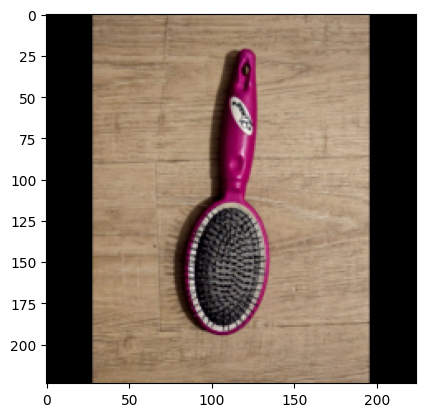

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.1698044..1.1044314].


This is classed as: Black
The model predicted class: TTR


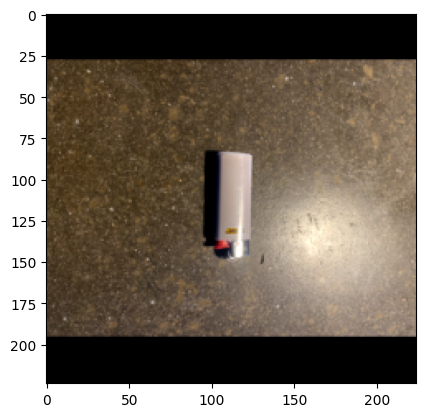

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.1698044..0.9295363].


This is classed as: Black
The model predicted class: TTR


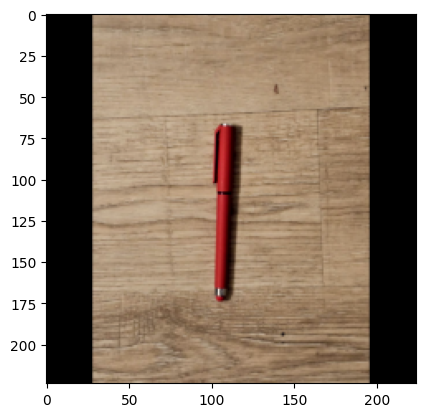

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.1698044..1.0844433].


This is classed as: Black
The model predicted class: TTR


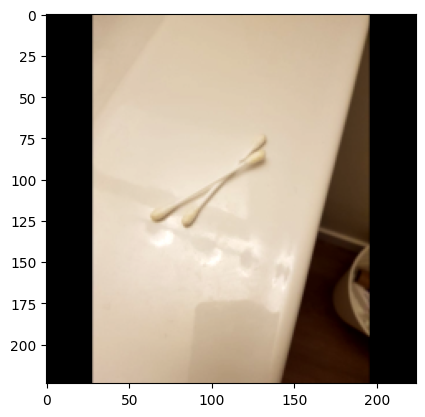

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.1698044..1.0910114].


This is classed as: Black
The model predicted class: Blue


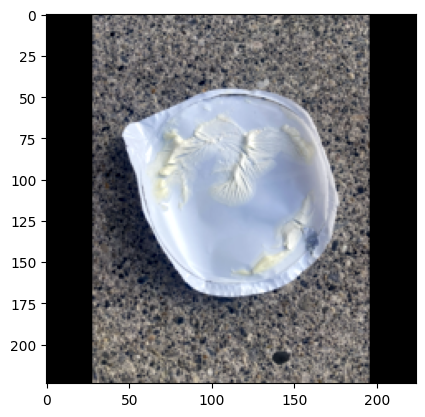

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.1698044..1.1044314].


This is classed as: Black
The model predicted class: TTR


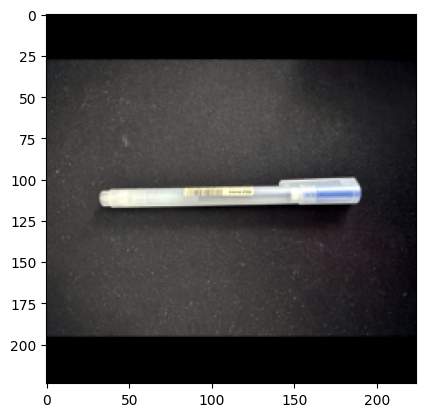

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.1698044..1.0744493].


This is classed as: Black
The model predicted class: TTR


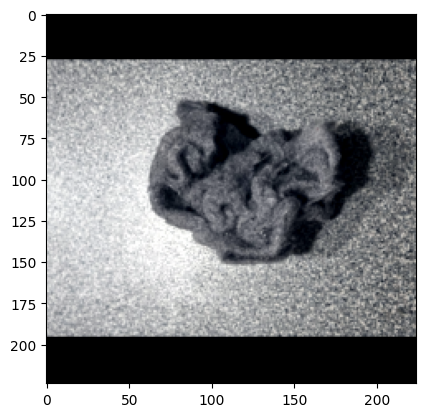

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.1698044..0.9195423].


This is classed as: Black
The model predicted class: Blue


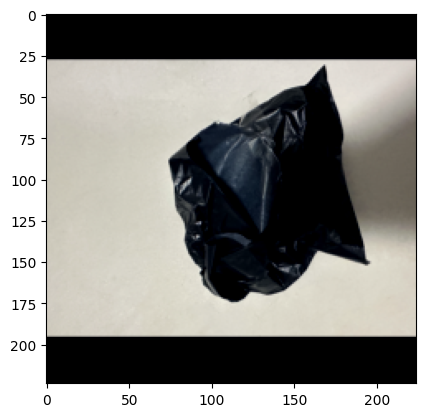

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.1698044..1.1044314].


This is classed as: Black
The model predicted class: TTR


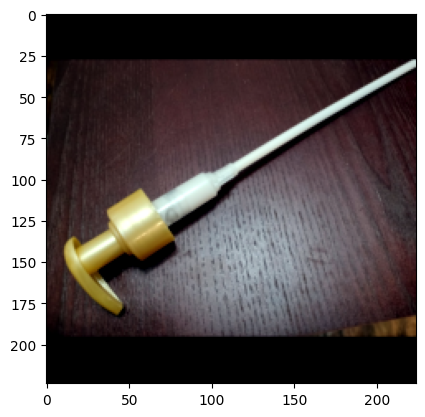

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.1698044..1.0894403].


This is classed as: Black
The model predicted class: Green


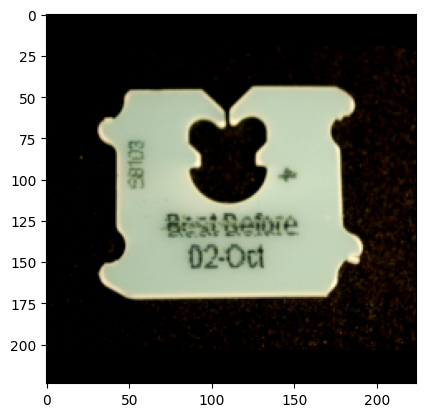

This is classed as: Black
The model predicted class: Green


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.1698044..1.0815682].


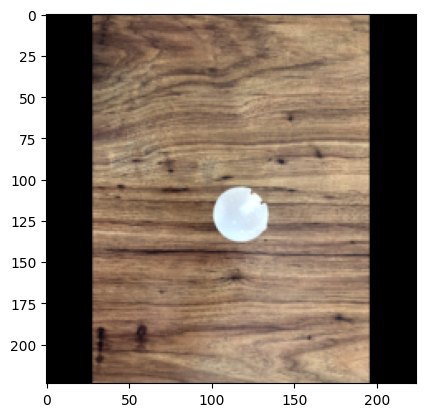

Accuracy for class: Black is 83.7 %
Accuracy for class: Blue  is 89.0 %
Accuracy for class: Green is 96.9 %
Accuracy for class: TTR   is 83.0 %


In [41]:
predictALL(model, dataloaders['test'], device, class_names)

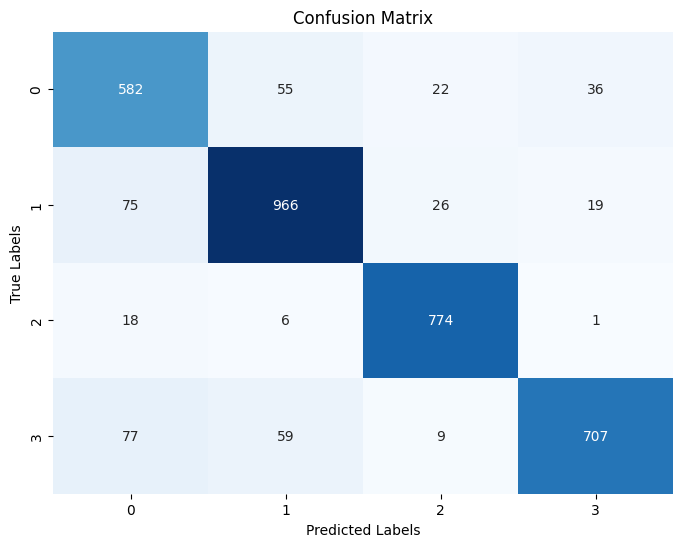

In [10]:
cm = confusion_matrix(labels_test, test_predictions)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, cmap='Blues', fmt='g', cbar=False)

plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()